## Packages

In [1]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import math
import torch
import os
import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC

from sklearn.model_selection import train_test_split

## Setup

In [3]:
def g(x):
    return -torch.sin(6 * math.pi * x)**2 - 6*(x**2) - 5 * (x**4) + 3/2

In [4]:
def generate_dataset(random_state):
    l = 30
    xis = torch.tensor(np.linspace(0,1,l))
    yis = g(xis) + np.random.normal(0, 0.01, len(xis))
    xis_train, xis_test, yis_train, yis_test = train_test_split(xis,  yis, test_size=0.33, random_state = random_state)
    return xis_train, xis_test, yis_train, yis_test

xis_train, xis_test, yis_train, yis_test = generate_dataset(random_state = 0)
order = np.argsort(xis_train)
xis_train = xis_train[order]
yis_train = yis_train[order]
test_order = np.argsort(xis_test)
xis_test = xis_test[test_order]
yis_test = yis_test[test_order]

In [5]:
print(xis_train)
print(g(xis_train))
print(yis_train)

tensor([0.0000, 0.0345, 0.1034, 0.1379, 0.1724, 0.2069, 0.2414, 0.2759, 0.3103,
        0.4138, 0.4828, 0.5172, 0.5517, 0.6207, 0.6552, 0.6897, 0.7241, 0.7931,
        0.8621, 1.0000], dtype=torch.float64)
tensor([ 1.5000,  1.1266,  0.5722,  1.1182,  1.3055,  0.7611,  0.1596,  0.2339,
         0.6994, -0.6710, -0.2719, -0.5651, -1.4748, -2.1345, -2.0430, -2.6611,
        -3.8017, -4.7253, -5.9862, -9.5000], dtype=torch.float64)
tensor([ 1.4922,  1.1297,  0.5772,  1.1227,  1.3178,  0.7720,  0.1396,  0.2296,
         0.7020, -0.6775, -0.2826, -0.5614, -1.4884, -2.1216, -2.0299, -2.6679,
        -3.7901, -4.7256, -5.9716, -9.5014], dtype=torch.float64)


<Axes: xlabel='None', ylabel='None'>

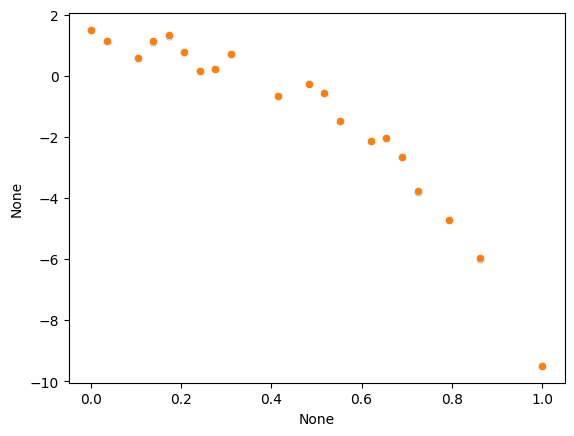

In [6]:
sns.scatterplot(x = xis_train, y = g(xis_train))
sns.scatterplot(x = xis_train, y = yis_train)



## Model

In [7]:
pyro.clear_param_store()
###Priors over kernel parameters
variance_prior = dist.Normal(torch.tensor(1.0), torch.tensor(1.0))  # Prior for variance
lengthscale_prior = dist.Normal(torch.tensor(1.0), torch.tensor(1.0))  # Prior for lengthscale
period_prior = dist.HalfNormal(torch.tensor(0.2))
#period_prior = dist.Normal(torch.tensor(0.2), torch.tensor(0.1))  # Prior for period
#noise could also be sampled from a prior?
noise_prior = dist.HalfNormal(torch.tensor(0.2))  # Prior for noise

###Sample from priors
variance = pyro.sample("variance", variance_prior)
lengthscale = pyro.sample("lengthscale", lengthscale_prior)
period = pyro.sample("period", period_prior)
noise = pyro.sample("noise", noise_prior)#pyro.param("noise", torch.tensor(0.01), constraint=dist.constraints.positive)

In [8]:
pyro.clear_param_store()

period_kernel = gp.kernels.Periodic(
    input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
)

rbf_kernel = gp.kernels.RBF(
    input_dim = 1, variance = variance, lengthscale=lengthscale
)

combined_kernel = gp.kernels.Product(
    period_kernel, rbf_kernel
)

kernel = combined_kernel

gpr = gp.models.GPRegression(xis_train, yis_train, kernel, noise=noise)

In [9]:
gpr

GPRegression(
  (kernel): Product(
    (kern0): Periodic()
    (kern1): RBF()
  )
)

In [10]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(xis_train.numpy(), yis_train.numpy(), "x", label = 'train data', c = 'yellow')
        ax.plot(xis_test.numpy(), yis_test.numpy(), "x", label = 'test data', c = 'black')
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(xis_train, full_cov=True)
            else:
                mean, cov = model(xis_train, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(xis_train.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            xis_train.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        ax.legend()

    if n_prior_samples > 0:  # plot samples from the GP prior
        xs_test = torch.linspace(0, 1, n_test)
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(xs_test) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(xs_test.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(0, 1)


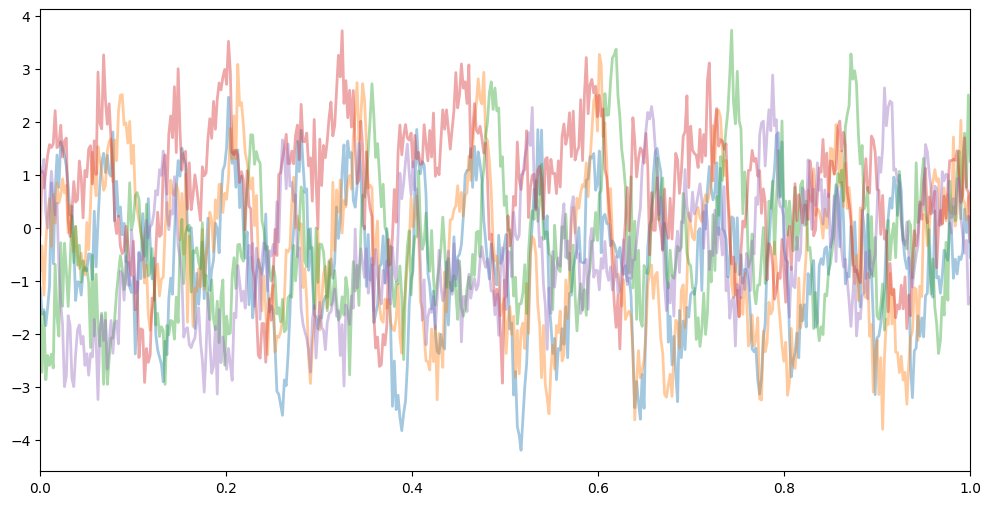

In [11]:
plot(model=gpr, kernel=kernel, n_prior_samples=5)
#_ = plt.ylim((-8, 8))

## MAP estimate

In [12]:
pyro.clear_param_store()

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



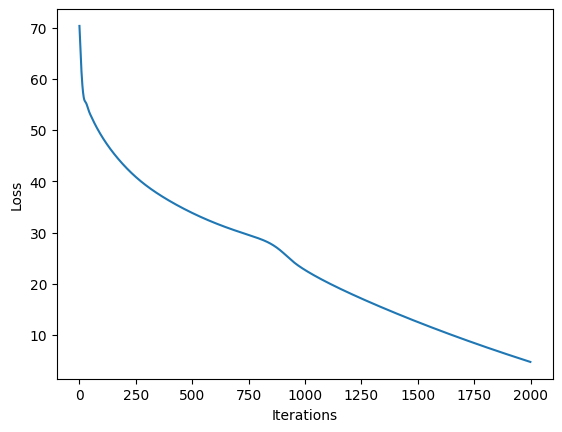

In [13]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

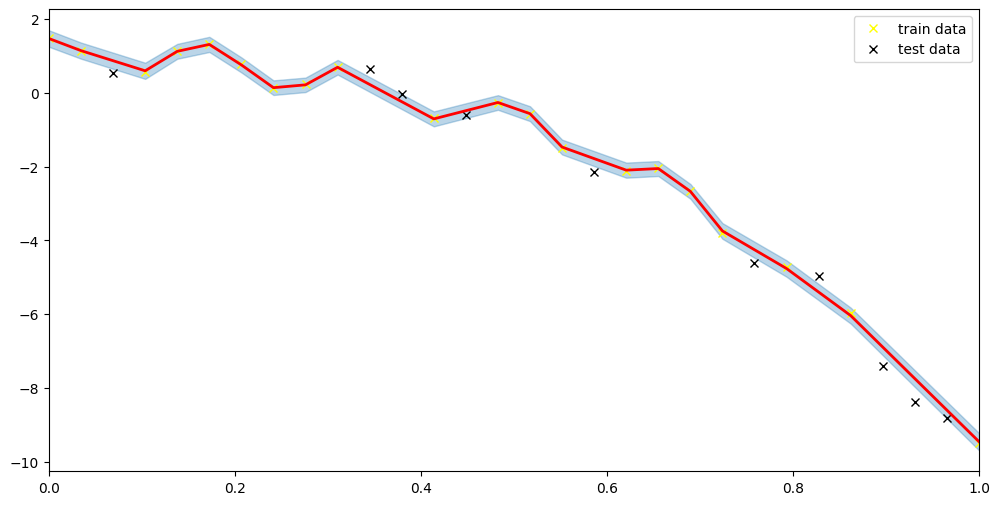

In [14]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [15]:
#print(gpr.kernel.variance.item())
#print(gpr.kernel.lengthscale.item())
#print(gpr.kernel.period.item())
#print(gpr.noise.item())

In [16]:
"""
figs, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].plot(variances, color = 'blue')
axs[0].set_title('Evolution of variance parameter')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('variance')

axs[1].plot(lengthscales, color = 'red')
axs[1].set_title('Evolution of lengthscale parameter')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('lengthscale')

axs[2].plot(periods, color = 'yellow')
axs[2].set_title('Evolution of period parameter')
axs[2].set_xlabel('iteration')
axs[2].set_ylabel('period')

axs[3].plot(noises, color = 'green')
axs[3].set_title('Evolution of noise parameter')
axs[3].set_xlabel('iteration')
axs[3].set_ylabel('noise')
"""

"\nfigs, axs = plt.subplots(1,4, figsize=(20,5))\naxs[0].plot(variances, color = 'blue')\naxs[0].set_title('Evolution of variance parameter')\naxs[0].set_xlabel('iteration')\naxs[0].set_ylabel('variance')\n\naxs[1].plot(lengthscales, color = 'red')\naxs[1].set_title('Evolution of lengthscale parameter')\naxs[1].set_xlabel('iteration')\naxs[1].set_ylabel('lengthscale')\n\naxs[2].plot(periods, color = 'yellow')\naxs[2].set_title('Evolution of period parameter')\naxs[2].set_xlabel('iteration')\naxs[2].set_ylabel('period')\n\naxs[3].plot(noises, color = 'green')\naxs[3].set_title('Evolution of noise parameter')\naxs[3].set_xlabel('iteration')\naxs[3].set_ylabel('noise')\n"

In [17]:
with torch.no_grad():
    predictive_mean, predictive_cov = gpr(xis_test, full_cov=True, noiseless=False)

    predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

    log_likelihood = predictive_distribution.log_prob(yis_test)

    print(f"Posterior Log-Likelihood on Test Set: {log_likelihood.item()}")

Posterior Log-Likelihood on Test Set: 10.761919864402932


## NUTS sampling

In [37]:
pyro.clear_param_store()
def model():
    ###Sample from priors
    variance = pyro.sample("variance", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance, lengthscale=lengthscale
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(xis_train, yis_train, kernel, noise=noise)

    return gpr.model

In [33]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_samples=1500, warmup_steps=500, num_chains = 4)
mcmc.run()
samples = mcmc.get_samples()

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 2000/2000 [01:03, 31.69it/s, step size=3.73e-01, acc. prob=0.929]


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  1.000  0.962  -0.920    2.688      0.015    0.011    4118.0   
noise        0.161  0.121   0.000    0.374      0.002    0.001    2263.0   
period       0.160  0.121   0.000    0.379      0.002    0.001    3079.0   
variance     1.013  0.996  -0.859    2.847      0.014    0.011    5066.0   

             ess_tail  r_hat  
lengthscale    3654.0    1.0  
noise          1720.0    1.0  
period         2205.0    1.0  
variance       4320.0    1.0  


array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

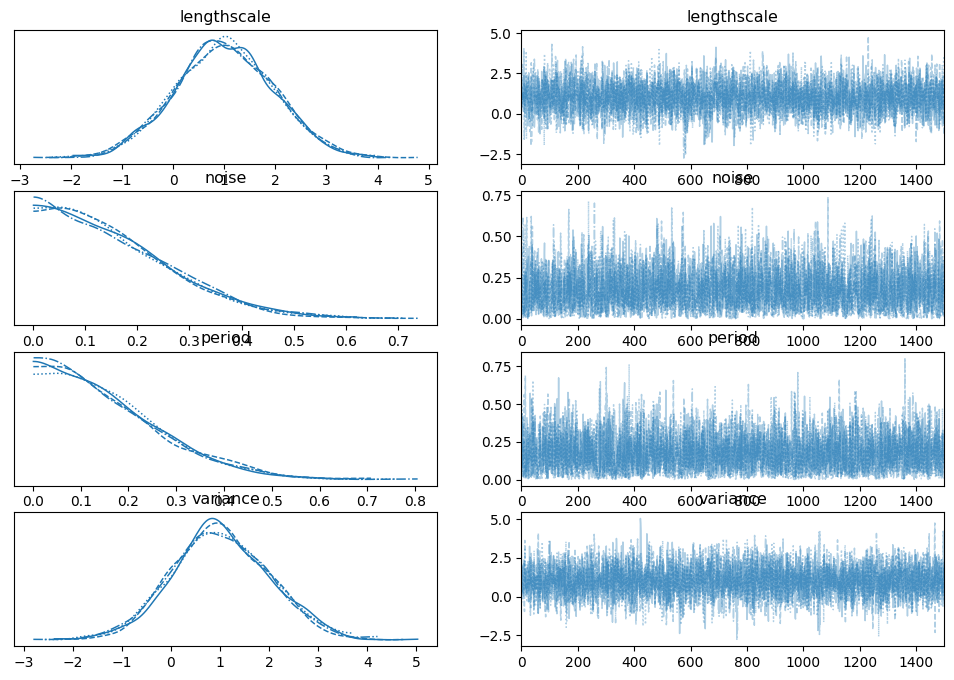

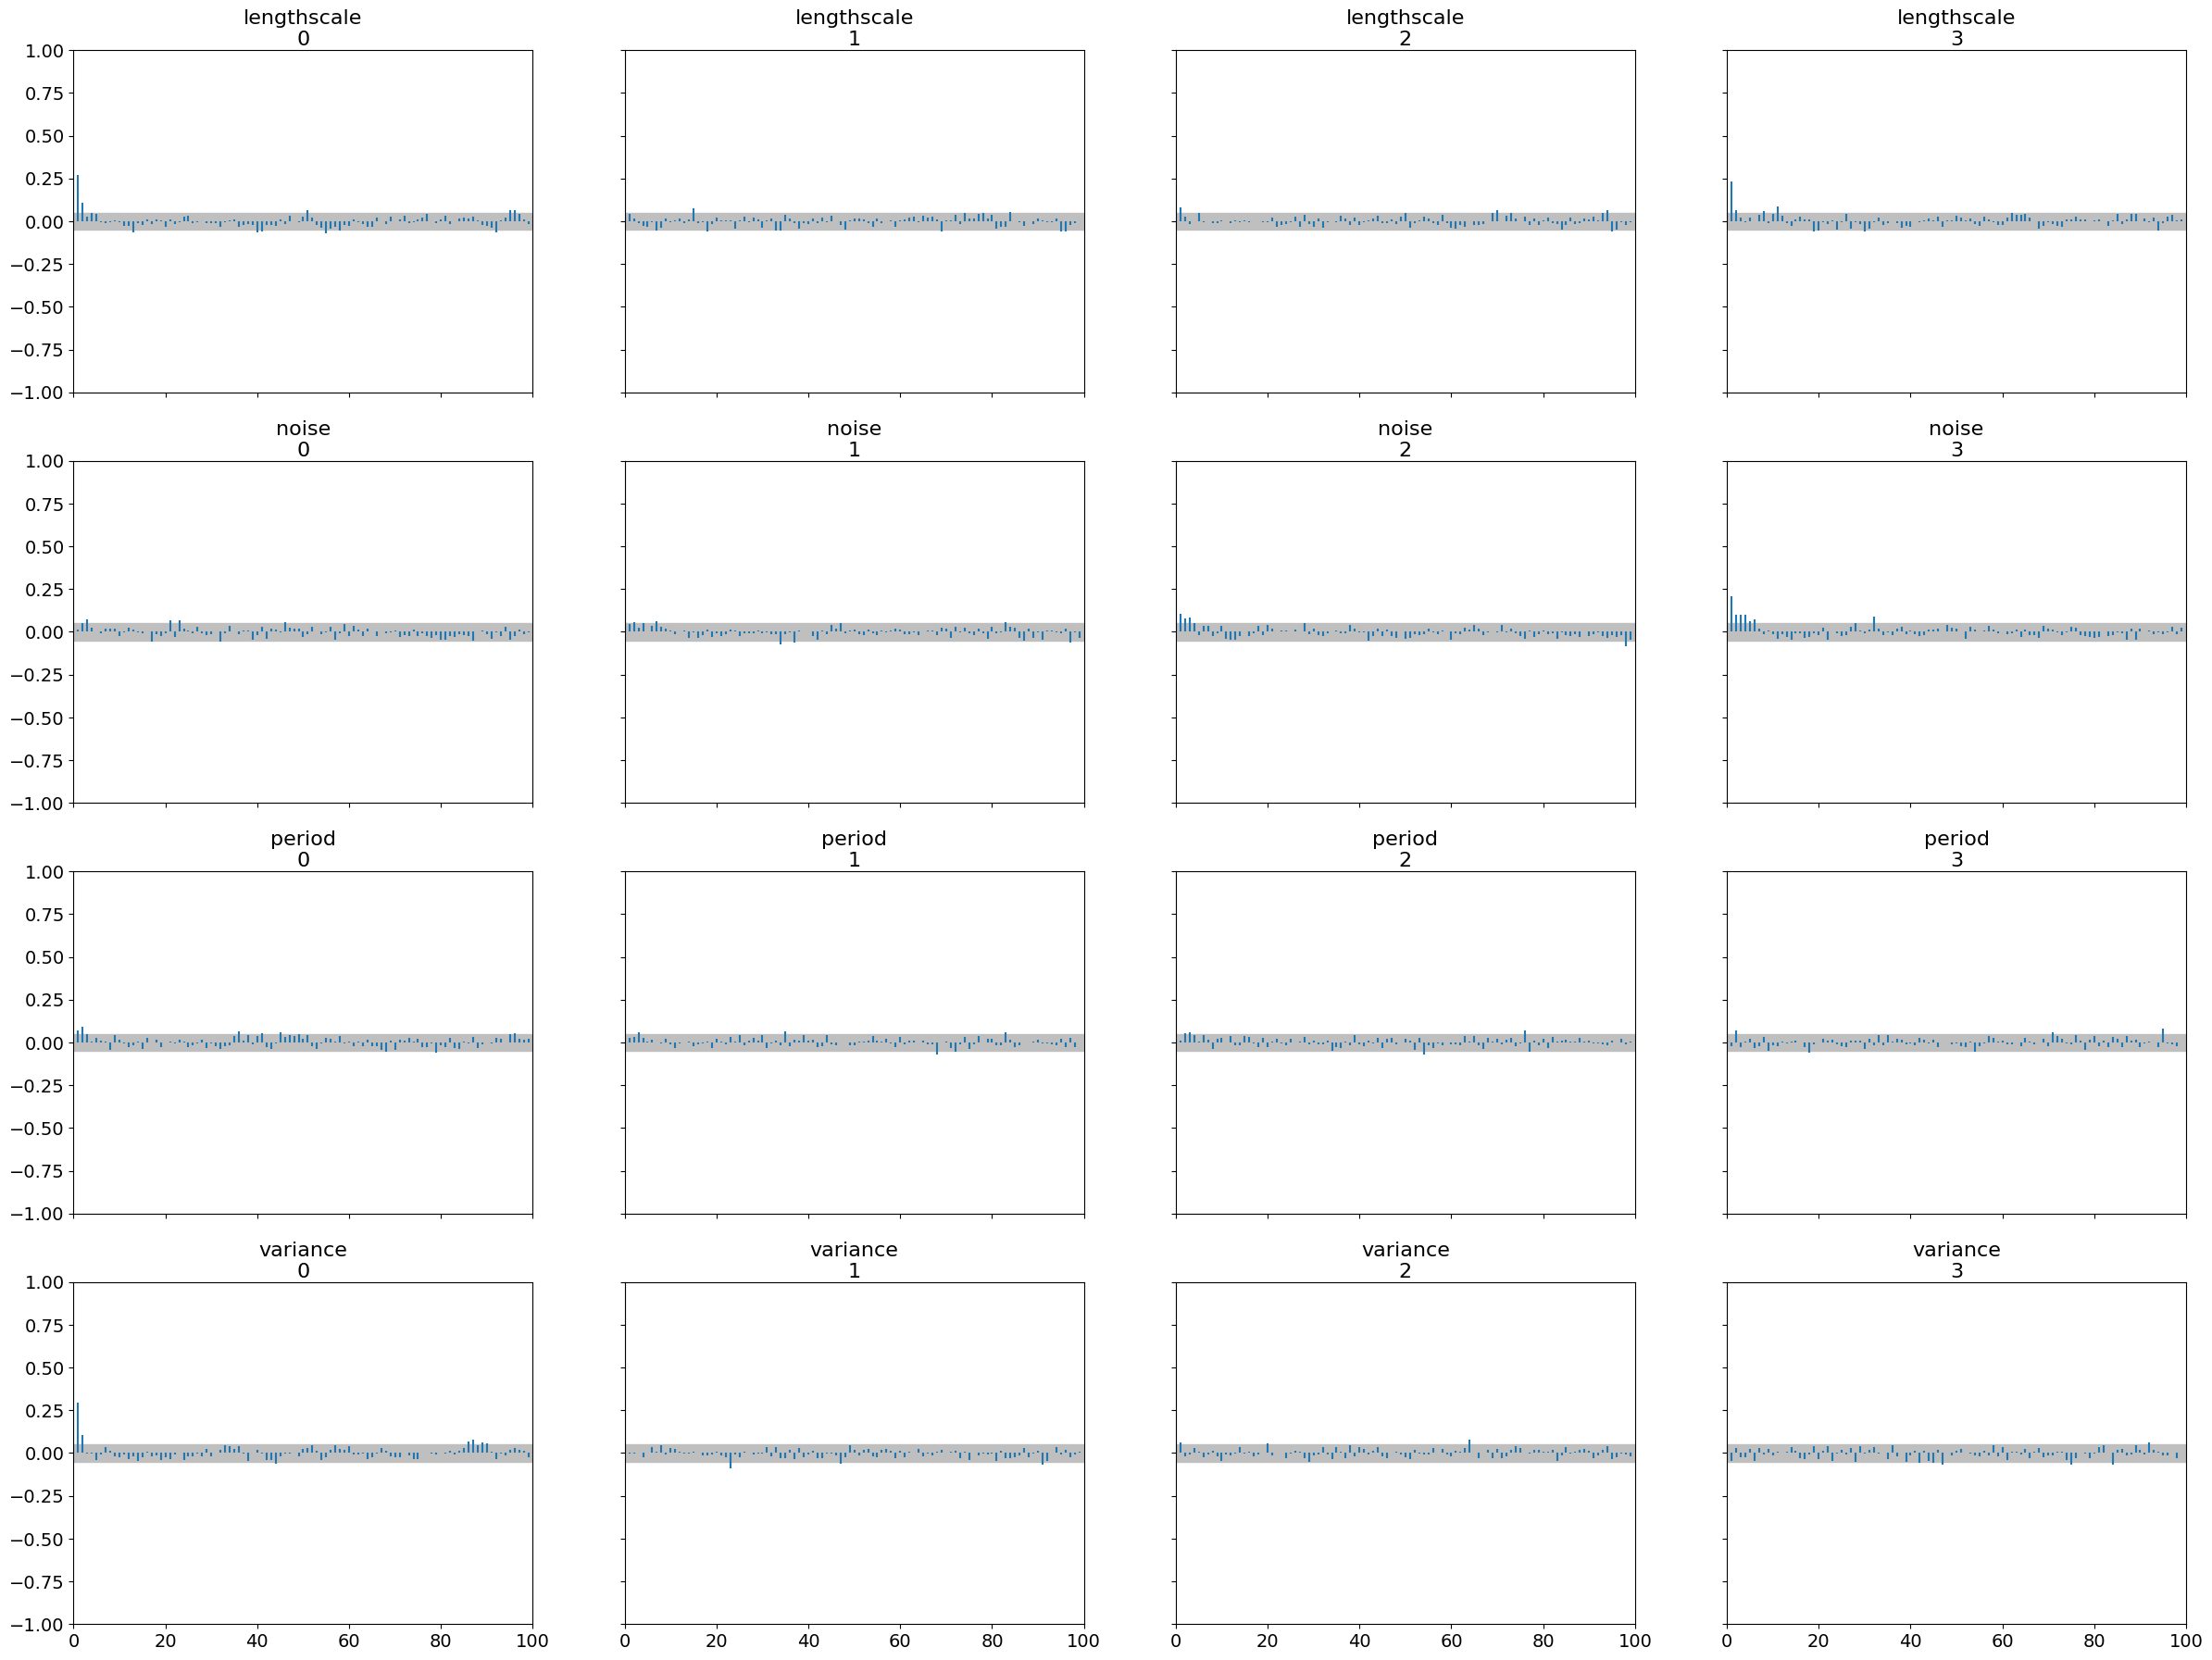

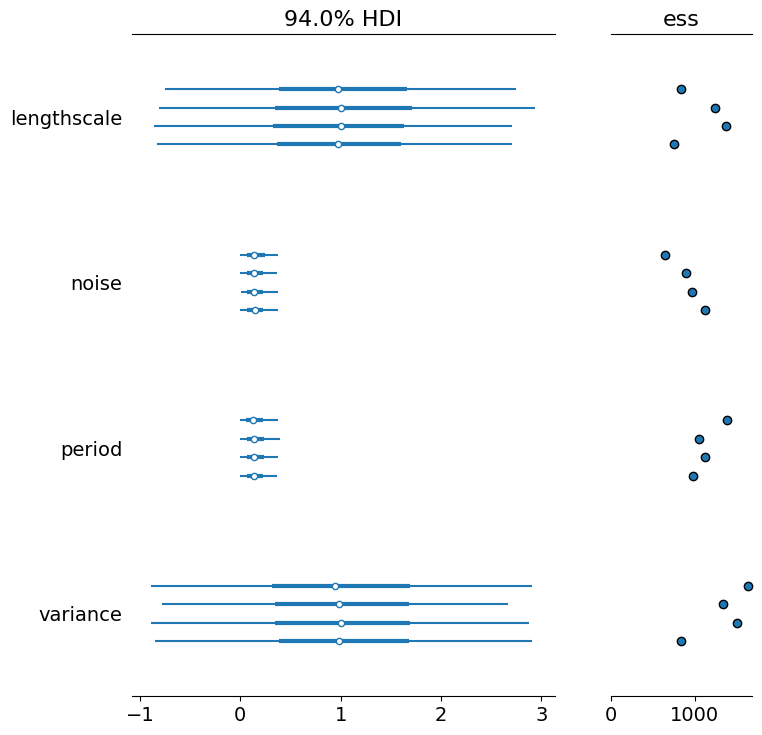

In [34]:
###Arviz diagnostics

posterior_data = az.from_pyro(mcmc)

print(az.summary(posterior_data))
az.plot_trace(posterior_data)
az.plot_autocorr(posterior_data)
az.plot_forest(posterior_data, ess = True)

# Test

In [35]:
# Get parameter samples
sampled_variances = samples["variance"].detach().numpy()
sampled_lengthscales = samples["lengthscale"].detach().numpy()
sampled_periods = samples["period"].detach().numpy()
sampled_noises = samples["noise"].detach().numpy()

# Select 500 random samples
num_samples_to_use = 500
selected_indices = np.random.choice(len(sampled_variances), num_samples_to_use, replace=False)

selected_variances = sampled_variances[selected_indices]
selected_lengthscales = sampled_lengthscales[selected_indices]
selected_periods = sampled_periods[selected_indices]
selected_noises = sampled_noises[selected_indices]

# Compute the approximate posterior log-likelihood
log_likelihoods = []

for var, length, period, noise in zip(selected_variances, selected_lengthscales, selected_periods, selected_noises):
    # Create a GP model with the current parameters
    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = torch.tensor(var), lengthscale=torch.tensor(length), period=torch.tensor(period)
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = torch.tensor(var), lengthscale=torch.tensor(length)
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel
    # We will create a new GP model to evaluate in the test set, so we use None instead of xis_train and yis_train here
    gpr = gp.models.GPRegression(xis_train, yis_train, kernel, noise=torch.tensor(noise))

    # Compute predictive distribution
    with torch.no_grad():
        predictive_mean, predictive_cov = gpr(xis_test, full_cov=True, noiseless=False)

    # Create a multivariate normal distribution
    predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

    # Compute log-likelihood of the test outputs
    log_likelihood = predictive_distribution.log_prob(yis_test)
    log_likelihoods.append(log_likelihood.item())

# Approximate posterior log-likelihood (in log space)
approximate_posterior_log_likelihood = sum(log_likelihoods) / len(log_likelihoods)

print(f"Approximate Posterior Log-Likelihood on Test Set: {approximate_posterior_log_likelihood}")

Approximate Posterior Log-Likelihood on Test Set: -51.148872236472734


In [39]:
samples['variance'].shape

torch.Size([6000])

## Test

In [ ]:
pyro.clear_param_store()
def model():
    ###Sample from priors
    variance = pyro.sample("variance", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance, lengthscale=lengthscale
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(xis_train, yis_train, kernel, noise=noise)

    return gpr.model